In [1]:
from IO.stero import *
import pickle
import scanpy as sc
import squidpy as sq
from util import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [2]:
# Load the data
gem_df = read_gem_file('F:\Adult.gem')
df = enhance_df_info(gem_df, bin)
adata = get_annadata(df)

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

F:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

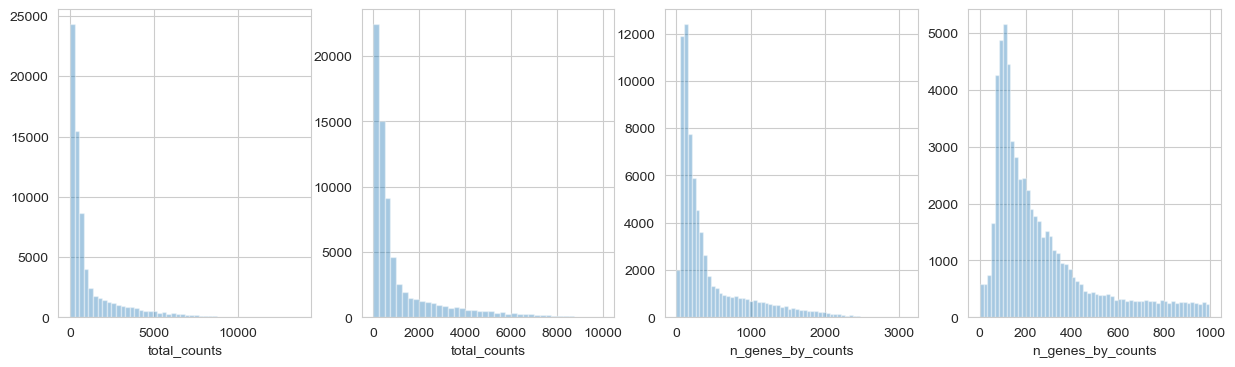

In [3]:
# filter out genes
sc.pp.filter_genes(adata, min_cells=50)
# Clean up data
sc.pp.calculate_qc_metrics(adata, inplace=True)
# Plot the raw data
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000], kde=False, bins=60, ax=axs[3])

In [4]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
# Select top 2000 variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [5]:
gene_list = list(adata.var['gene_ids'])
gene_list[:4]

['AMEX60DD000045', 'AMEX60DD000048', 'AMEX60DD000050', 'AMEX60DD000054']

In [11]:
gmm_dict = fit_gmms(adata, gene_list[:4], n_comp=10, thread=4)

In [8]:
gmm = fit_gmm(adata, 'AMEX60DD000045')
gmm

TypeError: int() argument must be a string, a bytes-like object or a number, not 'SparseCSRView'

In [17]:
adata.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '24388', '24516', '24594', '24684', '24701', '24930', '24950', '25070',
       '26107', '26242'],
      dtype='object', length=16261)

In [8]:
# cluster
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

In [9]:
sc.pl.spatial(adata, spot_size=1)

KeyError: "Could not find 'spatial' or 'X_spatial' in .obsm"

In [14]:
from scipy import sparse

# 创建一个稀疏矩阵实例作为参考类型
reference_sparse_matrix = csr_matrix([[1, 0, 2], [0, 3, 0]])

# 判断对象是否为 sparseCSRView 类型
obj = sparse.csr_matrix(reference_sparse_matrix)
is_sparse_csr_view = isinstance(obj, sparse.csr.spmatrix)
is_sparse_csr_view

C:\Users\pssun\AppData\Local\Temp\ipykernel_5420\2139089596.py:8: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  is_sparse_csr_view = isinstance(obj, sparse.csr.spmatrix)


True

In [13]:
sc.pp.filter_genes(adata, min_cells=50)
adata

AnnData object with n_obs × n_vars = 71998 × 16261
    obs: 'cell_id', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [101]:
import numpy as np
import scipy.sparse as sp

data = np.array(adata[:, adata.var_names == 'AMEX60DD000045'].X.todense())
sparse_matrix = sp.coo_matrix((data[:,0], (np.array(adata.obs['fig_x']), np.array(adata.obs['fig_y']))))
arr = np.array(sparse_matrix.todense(), dtype=np.int32)
result = matrix_to_list(arr)
gmm = mixture.GaussianMixture(n_components=10, max_iter=200)
gmm.fit(result)

GaussianMixture(max_iter=200, n_components=10)

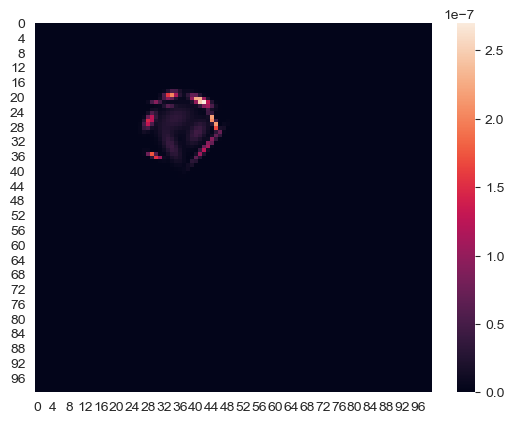

In [102]:
view_gmm(gmm,'2d')

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [8]:
H = get_coor_matrix(df)